In [1]:
from scipy.stats import special_ortho_group
import numpy as np
import random
import copy
import math
import sys
import os 
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, floatmode='maxprec')
np.set_printoptions(suppress=True)
from graphviz import Graph
from graphviz import Digraph

In [2]:
def dLdW(network, AminusG, L):
    network_copy = copy.deepcopy(network)
    mat_dot = np.eye(nNode)
    for l in range(L+1, nMatrix):
        mat_dot  = np.dot(mat_dot, np.transpose(network_copy[l]))
    mat_dot = np.dot(mat_dot, AminusG)
    min_mat = 0#np.min(np.delete(np.array(range(nMatrix)), L))
    #ここ0で良いのでは。
    for l in range(0, L):
        mat_dot  = np.dot(mat_dot, np.transpose(network_copy[l]))
    return(mat_dot)



def Loss(network, DesiredGoal):
    z = Total_in_out(network)
    fitness = np.sum((z - DesiredGoal)**2) #the sum of squares of elements
    return fitness

#Define fitness as the distance of goal matrix and total in-out matrix.
def evaluation(Ind_network, DesiredGoal):
    z = Total_in_out(Ind_network)
    fitness = -1*np.sum((z - DesiredGoal)**2) #the sum of squares of elements
    return fitness

def Total_in_out(Ind):
    z = np.dot(Ind[nMatrix -1], Ind[nMatrix -2])
    for i in range(nMatrix -3, -1, -1):
        z = np.dot(z, Ind[i])
    return z


def Relative_fitness_in_layer(layer, mode, network, orig_fit):
    relative_fitness = [(Deleted_fitness(network, node, layer)/orig_fit) for node in range(nNode)]
    relative_fitness_in_layer = relative_fitness/sum(relative_fitness)
    active_node_test = np.where(relative_fitness_in_layer > 0.001,  1, 0)
    if mode == "result":
        return(sum(active_node_test))
    elif mode == "test":
        return(active_node_test)

def Deleted_fitness(network, node, layer):    
    modified_network =  copy.deepcopy(network)
    Input_link_layer = layer - 1
    Output_link_layer = layer
    if layer == 0: #Eliminate input layer
        modified_network[Output_link_layer][:,node] = 0  #eliminate output
    elif layer == nLayer-1: #Eliminate output layer
        modified_network[Input_link_layer][node,] = 0   #eliminate input
    else: #Eliminate intermidiate layer
        modified_network[Input_link_layer][node,] = 0   #eliminate input from 
        modified_network[Output_link_layer][:,node] = 0
    orig_fit = evaluation(network, DesiredGoal)
    modi_fit = evaluation(modified_network, DesiredGoal)
    relative_fitness = abs(orig_fit-modi_fit)
    return(relative_fitness)

def Active_node_simple_mode(network, mode):
    orig_fit = abs(evaluation(network, DesiredGoal))
    active_node_list = [Relative_fitness_in_layer(layer, mode, network, orig_fit) for layer in range(nLayer)]
    return(active_node_list)


def CreateRandomGoalMatrix(rank, norm):
    
    if nNode == 6:
        if rank == 1:
            G = np.full((6,6),10)
        if rank == 2:
            a = np.full((3,3),10)
            b = np.full((3,3),0)
            G = np.block([[a,b],[b,a]])
        if rank == 3:
            a = np.full((2,2),10)
            b = np.full((2,2),0)
            G = np.block([[a,b,b],[b,a,b], [b, b,a]])
        if rank == 6:
            #G = np.diag(np.repeat(10,6))
            pre_DesiredGoal = np.random.uniform(1, 1.5, (nNode, nNode))
            pre_goal_norm = np.linalg.norm(pre_DesiredGoal, ord="fro")
            DesiredGoal = (norm/pre_goal_norm)*pre_DesiredGoal
            return(DesiredGoal)
    if nNode == 2:
        if rank == 1:
            G = np.full((2,2),10)
        if rank == 2:
            pre_DesiredGoal = np.random.uniform(1, 1.5, (nNode, nNode))
            pre_goal_norm = np.linalg.norm(pre_DesiredGoal, ord="fro")
            DesiredGoal = (norm/pre_goal_norm)*pre_DesiredGoal
            return(DesiredGoal)
        
    #randomize matrix
    rot_m = special_ortho_group.rvs(nNode)
    pre_DesiredGoal = np.dot(rot_m, G)
    pre_DesiredGoal[pre_DesiredGoal < 0] = -1*pre_DesiredGoal[pre_DesiredGoal < 0]
    #Uniform frobenius norm
    pre_goal_norm = np.linalg.norm(pre_DesiredGoal, ord="fro")
    DesiredGoal = (norm/pre_goal_norm)*pre_DesiredGoal

    
    return(DesiredGoal)



def WriteNetwork_simple_mode(network, nNode, nLayer, count, tidyvisual):
    dg = Digraph(format='png')
    
    if tidyvisual:
        dg.attr('node', shape='circle', label='')
    else:
        dg.attr('node', shape='circle')
        
    active_node_arr = Active_node_simple_mode(network, "test")
    Loss_ = Loss(network, DesiredGoal)
    dg.attr(label="Generation:" + str(count) + "\l" + "fitness:" + str(np.round(Loss_,4)))
    for layer in range(nLayer):
        for node in range(nNode):
            width = active_node_arr[layer][node]
            name = str(layer)+str(node)
            if tidyvisual:
                if width:
                    dg.node(name, penwidth=str(width), style='filled', fillcolor='skyblue')
                else:
                    dg.node(name, penwidth=str(width))
            else:
                dg.node(name, penwidth=str(width))
    
    #Write links
    for layer in range(1, nLayer):
        for postnode in range(nNode):
            #row
            post = str(layer) + str(postnode)
            for prenode in range(nNode):
                #column
                pre= str(layer-1) + str(prenode)
                intensity =  network[layer-1][postnode, prenode]
                if intensity < 0:
                    color_ = "blue"
                    intensity = abs(intensity)
                else:
                    color_ = "black"
                
                if tidyvisual:
                    if active_node_arr[layer][postnode] & active_node_arr[layer-1][prenode]:
                        if intensity > 15:
                            intensity = 15
                        dg.edge(pre, post,  penwidth=str(intensity), arrowsize="0.5", color=color_)
                    else:
                        dg.edge(pre, post,  penwidth='0', arrowsize="0", color=color_)
                else:
                    dg.edge(pre, post,  penwidth=str(intensity), arrowsize="0", color=color_)
                
    return(dg)


In [7]:
from scipy.stats import special_ortho_group
#LB = 0.0
#UB = 0.1

CreateGif = False
if CreateGif:
    try:
        #SET RUN TITLE
        PRJ_TITLE = "GD_Init60R2_Try2"
        SavePath = "/Users/itoutouma/Aokiken_jupyter/BowTieEvo/temporal_stored_data/" + PRJ_TITLE
        os.chdir("/Users/itoutouma/Aokiken_jupyter/BowTieEvo/temporal_stored_data")
        os.makedirs("/Users/itoutouma/Aokiken_jupyter/BowTieEvo/temporal_stored_data/" + PRJ_TITLE + "/result/")
        os.getcwd()
    except:
        print("File exist")
        
def F(network):
    AminusG = Total_in_out(copy.deepcopy(network))-DesiredGoal
    grad = 2*np.array([dLdW(network, AminusG, l) for l in range(nMatrix)])
    return grad*network

norm = 0.001 #Total inout matrix norm of initial network
nNode = 2
nLayer = 3
nMatrix = nLayer-1
GOAL_RANK = 1
#eta = 0.0005 #learnig rate for gradient discend
#eta = 0.00001 
h = 0.0001 # step width for Runge kutta

active_node_list = list()

R1,R2, I1, I2 = list(), list(), list(), list(),
ActiveNodeList = list()

for z in range(1):
    pre_net =  np.random.uniform(0, 0.1, (nMatrix, nNode, nNode))
    pre_net_norm = (np.linalg.norm(Total_in_out(pre_net), ord="fro"))   
    normalizeF = (norm/pre_net_norm)**(1/(nMatrix))
    network = normalizeF*pre_net
    initial_network_size = np.linalg.norm(Total_in_out(network), ord=2)
    DesiredGoal = CreateRandomGoalMatrix(GOAL_RANK, 60)#np.array([[10,10],[10,10]])

    for run in range(10000000):

        loss = Loss(network, DesiredGoal)
        
        #### Runge-Kutta ####
        k_1 = h * F(network)
        k_2 = h * F(network -  k_1 /2)
        k_3 = h * F(network -  k_2 /2)
        k_4 = h * F(network - k_3)
        network = network - 1/6 * (k_1 + 2*k_2 + 2*k_3 + k_4 )
        #######################
        
        I1.append(network[0][0,0] + network[0][0,1])
        I2.append(network[0][1,0] + network[0][1,1])
        R1.append(network[1][0,0] + network[1][1,0])
        R2.append(network[1][0,1] + network[1][1,1])
        ActiveNode = Active_node_simple_mode(network, "result")
        ActiveNodeList.append(ActiveNode)
        
        if np.isnan(loss):
            print("Divergence")
            break

        if run%5000==0:
            print("========={}=========".format(run))
            ActiveNode = Active_node_simple_mode(network, "result")
            print("Active Node:{}".format(ActiveNode))
            print("Loss:{}".format(loss))
            #print("mean eta:{}".format(np.mean(eta)))
            if CreateGif:
                G = WriteNetwork_simple_mode(network, nNode, nLayer, run, tidyvisual=False)
                Gtitle = SavePath +"/"+  str((run)) + "Gen"
                G.render(Gtitle)

            if loss < 0.01: #Fitness < 0.01
                print("========={}=========".format(run))
                print("Convergence at {}".format(run))
                print("Loss:{}".format(loss))
                print("Active Node:{}".format(ActiveNode))
                break
    
    active_node_list.append(ActiveNode)
    print("Done")


=========0=========
Active Node:[2, 2, 2]
Loss:3599.8898910603693
=========5000=========
Active Node:[2, 1, 2]
Loss:6.460230201375159e-08
=========5000=========
Convergence at 5000
Loss:6.460230201375159e-08
Active Node:[2, 1, 2]
Done


### S7Fig B
- Simulation script: 'NetworkEvolution_ODE_SingleTest` (Set GoalMatrixVariance = 1)
> (B) Evolution toward the rank1 goal matrix (‖G‖_F=60) from the initial norm A_0= 0.01. Left panel: Evolutionary trajectories of the network. Y-axis: Number of nodes in each layer. The initial norm A_0 is 0.01.  Right panel: Evolutionary trajectory of I, R, and R-I. Solid lines show R_1, I_1 and R_1- I_1 and dashed lines show R_2, I_2 and R_2- I_2. The divergence of R_1 and I_1 is accompanied with the emergence of the narrow waist in the network.

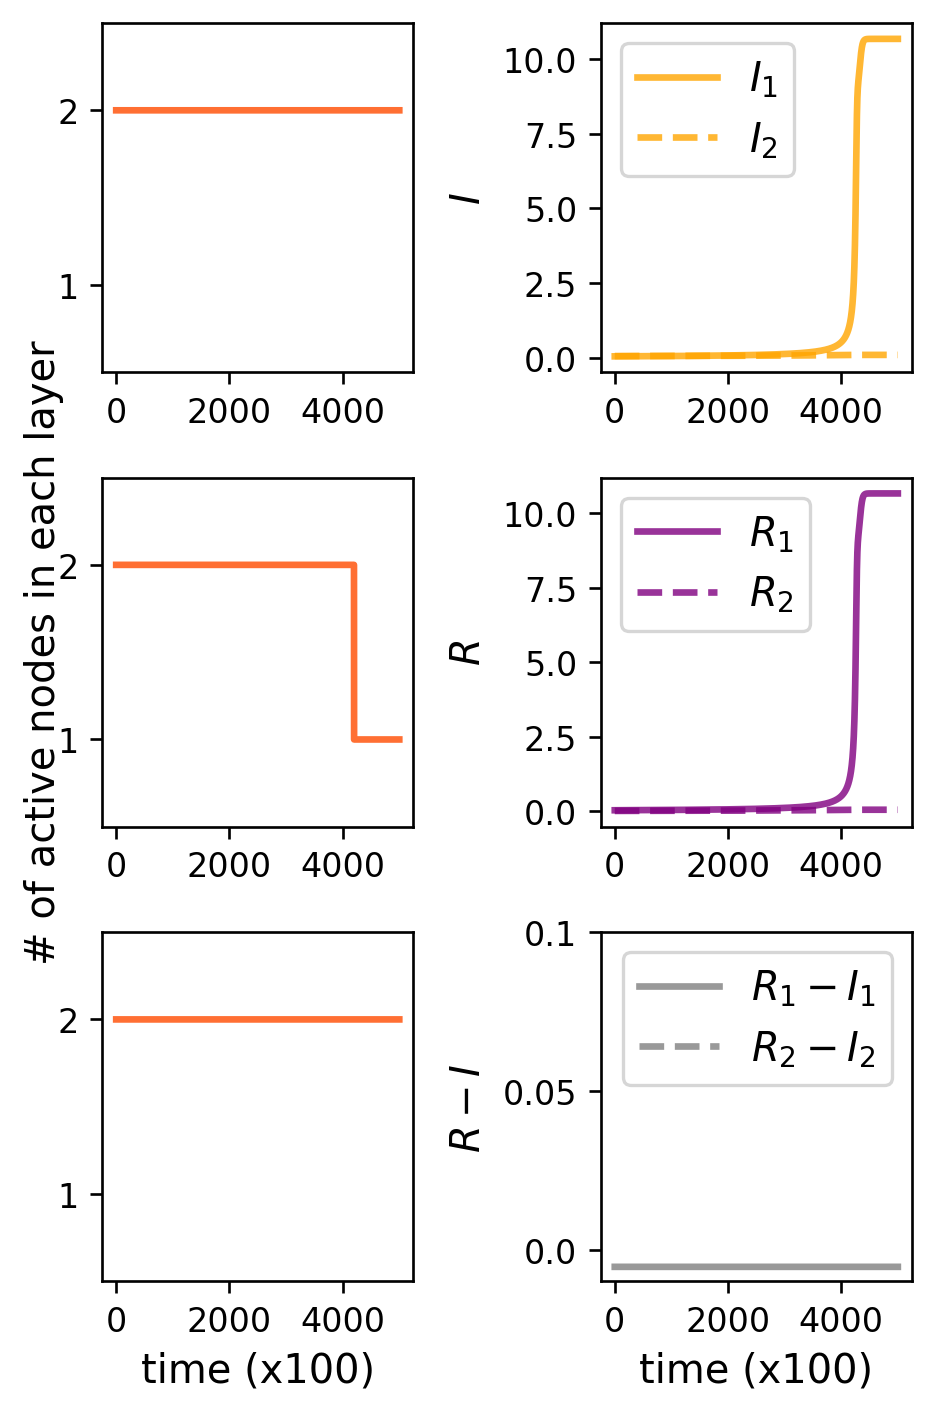

In [8]:
#fig = plt.figure(figsize=(6,6),facecolor="white")
fig = plt.figure(figsize=(4, 6),facecolor="white", dpi=240)
c1,c2 = "#ff4b00", "#005aff"
col1, col2, col3 = 0, 0, 0
ax = list(range(3*nLayer*2))
nNodeAlongTime = np.array(ActiveNodeList)

j = 0
colR, colI = "purple", "orange"
alp1, alp2 = 0.8, 0.8
I1 = np.array(I1)
R1 = np.array(R1)
I2 = np.array(I2)
R2 = np.array(R2)
for i in range(nLayer*2):
    ax[i] = fig.add_subplot(nLayer,2, i+1)
    if i%2 == 0:
        ax[i].plot(nNodeAlongTime[:,j], alpha=0.8, color=c1, linewidth=2)
        ax[i].set_ylim([0.5,2.5])
        ax[i].set_yticks([1,2])
        j += 1
    if i%2 == 1:
        if i == 1:
            ax[i].plot(I1, linewidth=2, color = colI, alpha=alp1, label="I1")
            ax[i].plot(I2, linewidth=2, linestyle="dashed", color = colI, alpha=alp2, label="I2")
            ax[i].set_ylabel("$I$", fontsize=12)
        elif i == 3:        
            ax[i].plot(R1, linewidth=2, color = colR, alpha=alp1, label="R1")
            ax[i].plot(R2, linewidth=2, linestyle="dashed", color = colR, alpha=alp2, label="R2")
            ax[i].set_ylabel("$R$", fontsize=12)
        elif i == 5:
            ax[i].plot(R1-I1, linewidth=2, color = "grey", alpha=alp2, label="I1-R1")
            ax[i].plot(R2-I2, linewidth=2, linestyle="dashed", color = "grey", alpha=alp2, label="I2-R2")
            ax[5].set_ylim([-0.01,0.1])
            ax[i].set_ylabel("$R - I$", fontsize=12)

ax[2].set_ylabel('# of active nodes in each layer', ha='center', va='center', size=12)
ax[1].legend(labels = ["$I_1$", "$I_2$"], fontsize=12)
ax[3].legend(labels = ["$R_1$", "$R_2$"], fontsize=12)
ax[5].legend(labels = ["$R_1 - I_1$", "$R_2 - I_2$"], fontsize=12)
ax[4].set_xlabel("time (x100)", fontsize=12)
ax[5].set_xlabel("time (x100)", fontsize=12)
ax[i].set_yticks([0.0, 0.05, 0.1])
ax[i].set_yticklabels([0.0, 0.05, 0.1])
plt.tight_layout()
#ax[1].legend(labels = ["rank2"])
#ax[2].legend(labels = ["rank3"])
#ax[3].legend(labels = ["rank6"])
#fig.savefig('/Users/itoutouma/Aokiken_jupyter/BowTieEvo/ResultFigures/R-I_time_evol_Rank1.pdf')

In [ ]:
pre_net =  np.random.uniform(0, 0.1, (nMatrix, nNode, nNode))
pre_net_norm = (np.linalg.norm(Total_in_out(pre_net), ord="fro"))   
normalizeF = (norm/pre_net_norm)**(1/(nMatrix))
network = normalizeF*pre_net*100
WriteNetwork_simple_mode(network, nNode, nLayer, run, tidyvisual=True)

### create gif animation

In [ ]:
import shutil
filelist = os.listdir(SavePath)
mvfiles = [s for s in filelist if "Gen.png" in s]
mvfilespath = [SavePath + "/"  + s for s in mvfiles]
for file in mvfilespath:
    shutil.move(file, SavePath + '/result')

In [ ]:
from PIL import Image
import glob
import re
 
def create_gif(in_dir, out_filename):
    print(*[in_dir, '*'])
    path_list = glob.glob(os.path.join(*[in_dir, '*']))
    sort_path_list = sorted(path_list , key=lambda x:int((re.search(r"[0-9]+", x)).group(0)))
    print(sort_path_list)
    imgs = []                                                   # 画像をappendするための空配列を定義
 
    # ファイルのフルパスからファイル名と拡張子を抽出
    for i in range(len(sort_path_list)):
        img = Image.open(sort_path_list[i])                          # 画像ファイルを1つずつ開く
        imgs.append(img)                                        # 画像をappendで配列に格納していく
    imgs[0].save(out_filename, save_all=True, append_images=imgs[1:], optimize=False, duration=10, loop=0)
    
os.chdir(SavePath)
create_gif(in_dir="./result", out_filename=SavePath + '/MostFitEvo.gif')